# Embedding Translations


see `plan.md` for more info


# 01 Setup


In [1]:
### LOCAL INSTALLS ###
%pip install torch
%pip install torchvision
%pip install torchaudio
%pip install datasets
%pip install click
%pip install scikit-learn
%pip install plotly
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
### GENERAL IMPORTS ###

### ML IMPORTS ###
import torch
from datasets import load_dataset
from torch import nn


from src.viz.owl_metrics import calculate_metric


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


device = torch.device("cuda:0")
# assert torch.cuda.is_available()

PyTorch version: 2.5.1
CUDA available: False


In [3]:
"""owler metrics document."""

import random
from typing import Any

import click
import numpy as np
import plotly.express as px
import torch
from sklearn.neighbors import NearestNeighbors
from torch.nn.functional import cosine_similarity
from torch.nn.functional import pairwise_distance


COSINE = "cosine"
EUCLIDEAN = "euclidean"
JACCARD = "jaccard"
RANK = "rank"
CKA = "cka"
AVAILABLE_METRICS = [COSINE, EUCLIDEAN, JACCARD, RANK, CKA]
MATCH_DIM_METRICS = [COSINE, EUCLIDEAN]
NEAREST_NEIGHBORS = [JACCARD, RANK]


def _pairwise_similarity(
    embeds1: torch.Tensor, embeds2: torch.Tensor, metric: str, device: torch.device
) -> torch.Tensor:
    """Calculates the pairwise cosine similarity or Euclidean distance between the given tensors.

    :param embeds1: The first tensors of dimension (N, D).
    :param embeds2: The second tensors of dimension (N, D).
    :param metric: The metric to be used.
    :param device: The device on which calculations are performed.
    :return: The calculated pairwise scores.
    """
    if metric == COSINE:
        return cosine_similarity(embeds1.to(device), embeds2.to(device))
    if metric == EUCLIDEAN:
        return pairwise_distance(embeds1.to(device), embeds2.to(device))
    raise NotImplementedError(f"Provided unsupported metric {metric} for pairwise similarity!")


def _mean_pairwise_similarity(
    embeds1: torch.Tensor, embeds2: torch.Tensor, metric: str, batch_size: int, device: torch.device
) -> torch.Tensor:
    """Calculates the pairwise cosine similarity or Euclidean distance between batches of the given tensors and sums them
    up. In the end, the mean score is returned.

    :param embeds1: A tensor of dimension (N, D).
    :param embeds2: A tensor of dimension (N, D).
    :param metric: The metric to use for calculating the pairwise scores.
    :param batch_size: The batch size used to split the tensors.
    :param device: The device on which calculations should be performed.
    :return: The mean score over all batches.
    """
    assert embeds1.shape == embeds2.shape
    embeds1_batches = embeds1.split(batch_size)
    embeds2_batches = embeds2.split(batch_size)
    total = 0
    sims = []
    for embed1, embed2 in zip(embeds1_batches, embeds2_batches, strict=False):
        sim = _pairwise_similarity(embed1, embed2, metric, device)
        sims = sims + sim.detach().cpu().tolist()
        total += torch.sum(sim).detach().cpu()
    text = "Cosine Similarities" if metric is COSINE else "Euclidean Distance"
    fig = px.histogram(x=sims, labels={"x": text}, title=f"{text} Distribution")
    return total / len(embeds1), fig


def _jaccard_sim(indices1: np.ndarray, indices2: np.ndarray) -> np.float64:
    """Calculates the Jaccard similarity between two 2D arrays by dividing the number of overlapping entries by the union
    of entries per row. The mean score over all rows is returned in the end.

    :param indices1: The first array of indices of shape (N, D).
    :param indices2: The second array of indices of shape (N, D).
    :return: The mean Jaccard similarity.
    """
    inds = np.concatenate((indices1, indices2), axis=1)
    len_union = np.array([len(np.unique(i)) for i in inds])
    len_intersection = np.array(
        [len(set(i).intersection(set(j))) for i, j in zip(indices1, indices2, strict=False)]
    )
    return np.mean(len_intersection / len_union)


def _get_rank_sum(indices1: np.ndarray, indices2: np.ndarray) -> Any:
    """Computes the sum term for rank similarity given the two 1D-arrays containing the indices of the k-nearest neighbors
    of two sets of activations.

    :param indices1: One row of indices calculated for the first set of activations.
    :param indices2: One row of indices calculated for the second set of activations.
    :return: The calculated rank sum.
    """
    aux = np.concatenate((indices1, indices2))
    aux_sort_indices = np.argsort(aux, kind="mergesort")
    aux = aux[aux_sort_indices]
    mask = aux[1:] == aux[:-1]
    ar1_indices = aux_sort_indices[:-1][mask] + 1
    ar2_indices = aux_sort_indices[1:][mask] - indices1.size + 1
    rank_sum = np.sum(
        [2 / ((1 + abs(i - j)) * (i + j)) for i, j in zip(ar1_indices, ar2_indices, strict=False)]
    )
    return rank_sum


def _rank_sim(indices1: np.ndarray, indices2: np.ndarray):
    """Computes the rank similarity between two sets of indices. Rank similarities are calculated for each pair of rows and
    averaged.

    :param indices1: The first array of indices of shape (N, D).
    :param indices2: The second array of indices of shape (N, D).
    :return: The mean rank similarity.
    """
    rank_sums = [_get_rank_sum(i, j) for i, j in zip(indices1, indices2, strict=False)]
    len_intersection = np.array(
        [len(set(i).intersection(set(j))) for i, j in zip(indices1, indices2, strict=False)]
    )
    factors = []
    for idx, elem1 in enumerate(len_intersection):
        if elem1 > 0:
            factors.append(1 / sum([1 / (i + 1) for i in range(int(elem1))]))
        else:
            factors.append(0)
    res = np.array(factors) * np.array(rank_sums)
    return np.mean(res)


def nn_sim(indices1: np.ndarray, indices2: np.ndarray, metric: str) -> Any:
    """Calculates the similarity of two sets of indices representing the index of nearest neighbors using Jaccard or rank
    similarity.

    :param indices1: The first array of indices of shape (N, D).
    :param indices2: The second array of indices of shape (N, D).
    :return: The average similarity.
    """
    if metric == JACCARD:
        return _jaccard_sim(indices1, indices2)
    return _rank_sim(indices1, indices2)


def _nearest_neighbors(
    embeds1: np.ndarray,
    embeds2: np.ndarray,
    queries1: np.ndarray,
    queries2: np.ndarray,
    metric: str,
    k: int,
    nn_function: str,
    baseline: bool = False,
) -> tuple[Any, None]:
    """Calculates the nearest neighbors for two sets of queries and returns the k indices of the closest embeddings for
    each query. After obtaining the indices, their similarity is calculated.

    :param embeds1: The first set of embeddings of shape (N, D1).
    :param embeds2: The second set of embeddings of shape (N, D2).
    :param queries1: The first set of queries of shape (M, D1).
    :param queries2: The second set of queries of shape (M, D2).
    :param metric: The metric to use for comparing nearest neighbors.
    :param k: The number of nearest neighbors to retrieve.
    :param nn_function: The metric to use for finding nearest neighbors.
    :param baseline: Whether to compute a baseline score, default: False.
    :return: A list of similarity scores of length k.
    """
    neigh1 = NearestNeighbors(n_neighbors=k, metric=nn_function, algorithm="brute")
    neigh1.fit(embeds1)

    neigh2 = NearestNeighbors(n_neighbors=k, metric=nn_function, algorithm="brute")
    neigh2.fit(embeds2)

    indices1 = neigh1.kneighbors(queries1, n_neighbors=k, return_distance=False)
    indices2 = neigh2.kneighbors(queries2, n_neighbors=k, return_distance=False)

    if baseline:
        np.random.shuffle(indices1)

    sims = []

    for i in range(k):
        j = i + 1
        sims.append(nn_sim(indices1[:, :j], indices2[:, :j], metric))
    return sims, None


# Code taken from https://haydn.fgl.dev/posts/a-better-index-of-similarity/
def _cka(A: torch.Tensor, B: torch.Tensor) -> tuple[Any, None]:
    # Mean center each neuron
    A = A - torch.mean(A, dim=0, keepdim=True)
    B = B - torch.mean(B, dim=0, keepdim=True)

    dot_product_similarity = torch.linalg.norm(torch.matmul(A.t(), B)) ** 2

    normalization_x = torch.linalg.norm(torch.matmul(A.t(), A))
    normalization_y = torch.linalg.norm(torch.matmul(B.t(), B))

    cka = dot_product_similarity / (normalization_x * normalization_y)

    dot_product_similarity.detach()
    normalization_x.detach()
    normalization_y.detach()
    A.detach()
    B.detach()
    del dot_product_similarity, normalization_x, normalization_y, A, B
    return cka, None


def _calculate_embed_metric(
    embeds1: torch.Tensor,
    embeds2: torch.Tensor,
    queries1: np.ndarray,
    queries2: np.ndarray,
    metric: str,
    batch_size: int,
    device: torch.device,
    k: int,
    nn_function: str,
    baseline: bool = False,
):
    """Calculates the similarity between two embedding matrices using the given metric.

    :param embeds1: Document embedding tensor of shape (N, D1).
    :param embeds2: Document embedding tensor of shape (N, D1) if the metric requires matching dimensions or (N, D2).
    :param queries1: Embedding of queries of shape (N, D1).
    :param queries2: Embedding of queries of shape (N, D2).
    :param metric: The metric to be used, required to be one of AVAILABLE_METRICS.
    :param batch_size: The batch size used to calculate pairwise similarity.
    :param device: The device on which calculations should be performed.
    :param k: The number of nearest neighbors to retrieve for Jaccard or rank similarity.
    :param nn_function: The function for determining nearest neighbors.
    :param baseline: Whether to compute a baseline score, default: False.
    :return: The calculated similarity.
    """
    assert len(embeds1) == len(embeds2)

    if metric in MATCH_DIM_METRICS:
        return _mean_pairwise_similarity(embeds1, embeds2, metric, batch_size, device)
    if metric in NEAREST_NEIGHBORS:
        return _nearest_neighbors(
            np.array(embeds1),
            np.array(embeds2),
            queries1,
            queries2,
            metric,
            k,
            nn_function,
            baseline,
        )
    if metric == CKA:
        return _cka(embeds1, embeds2)
    raise NotImplementedError(f"Provided unsupported metric {metric} for embedding similarity!")


def _sample_embeddings(
    embeds1: torch.Tensor,
    embeds2: torch.Tensor,
    min_size: int,
    num_embeds: int,
    baseline: bool = False,
):
    """Returns a subset of embeddings if the desired number of embeddings to be compared is lower than the available ones.
    If a baseline score should be computed, the first set of embeddings is shuffled randomly if all embeddings are used
    or two different random subsets are returned.

    :param embeds1: Document embedding tensor of shape (N, D1).
    :param embeds2: Document embedding tensor of shape (N, D1) if the metric requires matching dimensions or (N, D2).
    :param min_size: The maximum number of embeddings that can be compared.
    :param num_embeds: The number of embeddings that should be compared.
    :param baseline: Whether a baseline score should be computed.
    """
    if baseline:
        indices = torch.randperm(embeds1.shape[0])
        embeds1 = embeds1[indices]
    if num_embeds > 0:
        if min_size < num_embeds:
            click.echo(
                f"Chosen number of embeddings is larger than number of available ones {min_size}. "
                f"Using all available."
            )
        else:
            indices = random.sample(range(min_size), num_embeds)
            embeds1 = embeds1[indices]
            embeds2 = embeds2[indices]
    return embeds1, embeds2


def calculate_metric(
    embeds1: torch.Tensor,
    embeds2: torch.Tensor,
    queries1: np.ndarray,
    queries2: np.ndarray,
    metric: str,
    batch_size: int,
    device: torch.device,
    num_embeds: int,
    k: int,
    nn_function: str,
    center: bool = False,
    baseline: bool = False,
):
    """Calculates the similarity between document embeddings after pre-processing the embedding vectors.

    :param embeds1: Document embedding tensor of shape (N, D1).
    :param embeds2: Document embedding tensor of shape (N, D1) if the metric requires matching dimensions or (N, D2).
    :param queries1: Embedding of queries of shape (N, D1).
    :param queries2: Embedding of queries of shape (N, D2).
    :param metric: The metric to be used, required to be one of AVAILABLE_METRICS.
    :param batch_size: The batch size used to calculate pairwise similarity.
    :param device: The device on which calculations should be performed.
    :param num_embeds: The number of embeddings to be compared.
    :param k: The number of nearest neighbors to retrieve for Jaccard or rank similarity.
    :param nn_function: The function for determining nearest neighbors.
    :param center: Whether embeddings should be mean-centered, default: False.
    :param baseline: Whether to compute a baseline score, default: False.
    :return: The calculated similarity.
    """
    min_size = min(len(embeds1), len(embeds2))
    assert k <= min_size
    embeddings1 = embeds1[:min_size]
    embeddings2 = embeds2[:min_size]
    embeddings1, embeddings2 = _sample_embeddings(
        embeddings1, embeddings2, min_size, num_embeds, baseline
    )

    if center:
        embeddings1 = embeddings1 - torch.mean(embeddings1, axis=0, keepdim=True)
        embeddings2 = embeddings2 - torch.mean(embeddings2, axis=0, keepdim=True)

    return _calculate_embed_metric(
        embeddings1,
        embeddings2,
        queries1,
        queries2,
        metric,
        batch_size,
        device,
        k,
        nn_function,
        baseline,
    )


def self_sim_score(metric: str):
    """Returns the similarity score between two identical vectors for the given metric.

    :param metric: The name of the metric.
    :return: The self-similarity score.
    """
    if metric == COSINE or metric == JACCARD or metric == RANK or metric == CKA:
        return 1
    if metric == EUCLIDEAN:
        return 0
    raise NotImplementedError(
        f"Cannot return self-similarity score of unsupported metric {metric}!"
    )


In [41]:
from src.DataVizPipeline import DataVizPipeline
from safetensors.torch import load_file

# Create sample embeddings (100 documents, 768 dimensions each)
embeds1 = load_file(
    "/Users/gat/work/FA2024/embedding_translation/data/openai_embeddings/text-embedding-3-large/fiqa/corpus_validation_embeddings.safetensors"
)["embeddings"]
embeds2 = load_file(
    "/Users/gat/work/FA2024/embedding_translation/data/openai_embeddings/text-embedding-3-small/fiqa/corpus_validation_embeddings.safetensors"
)["embeddings"]


similarity_score = _cka(embeds1, embeds2)[0]

print(f"Similarity score: {similarity_score}")
plot = False
if plot:  # Plot will be None for some metrics
    plot.show()

Similarity score: 0.8972534537315369


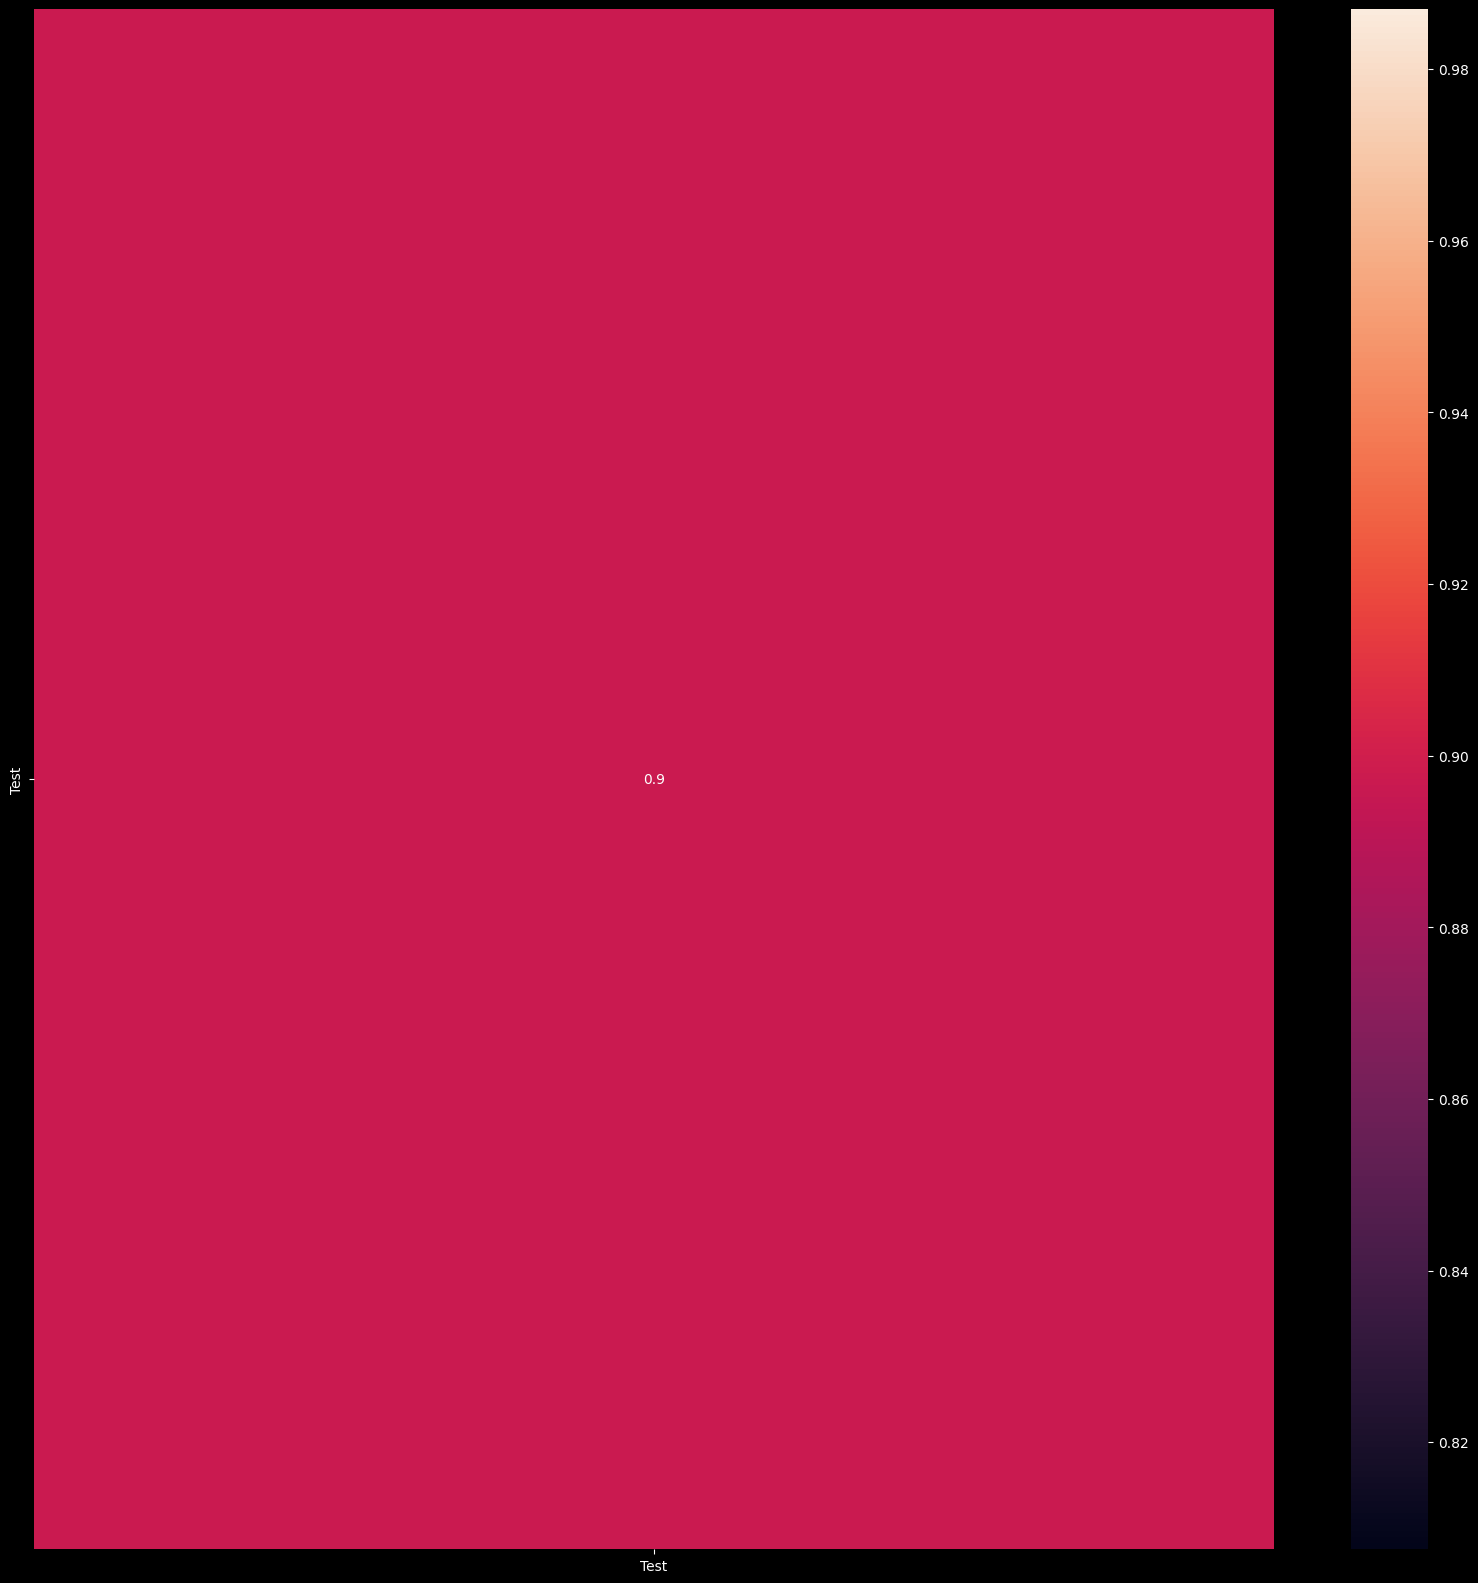

<Figure size 640x480 with 0 Axes>

In [5]:
# import numpy as np
# import os
# import pandas as pd
# import seaborn as sns

# from matplotlib import pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages


# def _save_heatmap(results: list, file_name: str, folder: str, models: list):
#     """
#     Creates a heatmap for the given scores of embedding similarity and saves them as a PDF.

#     :param results: A list containing similarity scores for each pair of models.
#     :param file_name: The name of the file that should be saved.
#     :param folder: The folder in which to save the file.
#     :param models: A list containing the names of all compared models.
#     """
#     fig, ax = plt.subplots(figsize=(20, 20))
#     df = pd.DataFrame(
#         np.array(results).reshape(len(models), len(models)), index=models, columns=models
#     )
#     sns.heatmap(data=df, ax=ax, annot=True)
#     plt.show()
#     file_name += ".pdf"
#     path = os.path.join(folder, file_name)
#     with PdfPages(path) as pdf:
#         plt.tight_layout()
#         pdf.savefig(fig, bbox_inches="tight")


# # _save_heatmap([similarity_score], "test", "data/figs", models=["Test"])

In [6]:
# from src.viz.plot_heatmap import visualize_heatmap
# from src.viz.save_figure import save_figure

# fig = visualize_heatmap(
#     matrix=[similarity_score],
#     config={
#         "row_labels": ["lol"],
#         "col_labels": ["lol"],
#         "title": "yar",
#         "xaxis_title": "Target Embedding Space",
#         "yaxis_title": "Native Embedding Space",
#     },
# )

# save_figure(fig, "lol")

[12/10/24 21:58:40] INFO      Starting heatmap visualization process                            ]8;id=136330;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py\plot_heatmap.py]8;;\:]8;id=374252;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py#115\115]8;;\

                    INFO      Creating heatmap visualization...                                  ]8;id=715310;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py\plot_heatmap.py]8;;\:]8;id=622582;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py#40\40]8;;\

                    SUCCESS   Heatmap created successfully                                       ]8;id=546893;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py\plot_heatmap.py]8;;\:]8;id=132923;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py#89\89]8;;\

                    INFO      Saving HTML figure to data/figs/html/lol.html                       ]8;id=990901;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py\save_figure.py]8;;\:]8;id=677512;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py#32\32]8;;\

                    SUCCESS   Successfully saved HTML to data/figs/html/lol.html                  ]8;id=286705;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py\save_figure.py]8;;\:]8;id=386881;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py#40\40]8;;\

                    INFO      Saving PNG figure to data/figs/imgs/lol.png                         ]8;id=494681;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py\save_figure.py]8;;\:]8;id=154043;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py#67\67]8;;\

[12/10/24 21:58:41] SUCCESS   Successfully saved PNG to data/figs/imgs/lol.png                    ]8;id=967358;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py\save_figure.py]8;;\:]8;id=421217;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py#76\76]8;;\

(PosixPath('data/figs/html/lol.html'), PosixPath('data/figs/imgs/lol.png'))

In [102]:
from pathlib import Path
from src.create_summaries_from_folder import ModelGenerator, anal_dump, EmbeddingDatasetInformation
from loguru import logger

__file__ = "/Users/gat/work/FA2024/embedding_translation/src/embedding_translation.ipynb"

PROJ_ROOT = Path(__file__).parent.parent
logger.info(PROJ_ROOT.resolve())

embeddings_dir = PROJ_ROOT / "data" / "huggingface_embeddings"
dataset_infos = ModelGenerator.native_embedding_dataset_info_from_dir(embeddings_dir)
logger.info(len(dataset_infos))

[12/10/24 23:01:48] INFO     [1381299790.py:8] /Users/gat/work/FA2024/embedding_translation         ]8;id=636547;file:///var/folders/6f/f4k9qbkd5nqfywwdhvwdtl5m0000gn/T/ipykernel_46672/1381299790.py\1381299790.py]8;;\:]8;id=378103;file:///var/folders/6f/f4k9qbkd5nqfywwdhvwdtl5m0000gn/T/ipykernel_46672/1381299790.py#8\8]8;;\

                    INFO     [1381299790.py:12] 66                                                 ]8;id=804790;file:///var/folders/6f/f4k9qbkd5nqfywwdhvwdtl5m0000gn/T/ipykernel_46672/1381299790.py\1381299790.py]8;;\:]8;id=327836;file:///var/folders/6f/f4k9qbkd5nqfywwdhvwdtl5m0000gn/T/ipykernel_46672/1381299790.py#12\12]8;;\

In [121]:
# Group em
dataset_infos_grouped: dict[str, list[tuple[EmbeddingDatasetInformation, torch.Tensor]]] = {}
for dataset_info in dataset_infos:
    if dataset_info.text_dataset_name in dataset_infos_grouped:
        pack = (dataset_info, load_file(dataset_info.dataset_filepath)["embeddings"])
        dataset_infos_grouped[dataset_info.text_dataset_name].append(pack)
    else:
        pack = (dataset_info, load_file(dataset_info.dataset_filepath)["embeddings"])
        dataset_infos_grouped[dataset_info.text_dataset_name] = [pack]

for text_dataset_name, datasets in dataset_infos_grouped.items():
    print(text_dataset_name)
    print(len(datasets))
    print(type(datasets[0][0]), type(datasets[0][1]))

fiqa
8
<class 'src.schema.training_schemas.EmbeddingDatasetInformation'> <class 'torch.Tensor'>
arguana
15
<class 'src.schema.training_schemas.EmbeddingDatasetInformation'> <class 'torch.Tensor'>
scidocs
9
<class 'src.schema.training_schemas.EmbeddingDatasetInformation'> <class 'torch.Tensor'>
trec-covid
6
<class 'src.schema.training_schemas.EmbeddingDatasetInformation'> <class 'torch.Tensor'>
hotpotqa
13
<class 'src.schema.training_schemas.EmbeddingDatasetInformation'> <class 'torch.Tensor'>
nfcorpus
15
<class 'src.schema.training_schemas.EmbeddingDatasetInformation'> <class 'torch.Tensor'>


In [122]:
# Add random cka to all dataset_infos
def add_random(dataset_infos_grouped):
    for text_dataset_name, datasets in dataset_infos_grouped.items():
        print(text_dataset_name)
        print(len(datasets))
        random_name = "Normal(0, 1)"
        if random_name in [dataset[0].embedding_model_name for dataset in datasets]:
            continue
        info = datasets[0][0].model_copy()
        info.dataset_filepath = None
        info.embedding_model_name = "Normal(0, 1)"
        embed = torch.randn_like(datasets[0][1])
        datasets.append((info, embed))
        print(len(datasets))


add_random(dataset_infos_grouped=dataset_infos_grouped)

fiqa
8
9
arguana
15
16
scidocs
9
10
trec-covid
6
7
hotpotqa
13
14
nfcorpus
15
16


In [124]:
num_embeds = len(dataset_infos)
cka_matrices = {}

for text_dataset_name, datasets in dataset_infos_grouped.items():
    if text_dataset_name != "arguana":
        continue
    cka_matrix = [[None for _ in datasets] for _ in datasets]
    print(text_dataset_name)
    for i, (info1, embeds1) in enumerate(datasets):
        print(f"{i} of {len(datasets)}")
        for j, (info2, embeds2) in enumerate(datasets):
            sim = _cka(embeds1, embeds2)[0]
            cka_matrix[i][j] = sim
    cka_matrices[text_dataset_name] = torch.Tensor(cka_matrix)

print(cka_matrices)

arguana
0 of 16
1 of 16
2 of 16
3 of 16
4 of 16
5 of 16
6 of 16
7 of 16
8 of 16
9 of 16
10 of 16
11 of 16
12 of 16
13 of 16
14 of 16
15 of 16
{'arguana': tensor([[1.0000, 0.8658, 0.8345, 0.9794, 0.8648, 0.9419, 0.8351, 0.9951, 0.7825,
         0.7811, 0.7877, 0.7567, 0.7575, 0.7686, 0.7938, 0.1314],
        [0.8658, 1.0000, 0.8502, 0.8600, 0.9441, 0.8646, 0.8449, 0.8768, 0.7742,
         0.7731, 0.7888, 0.7581, 0.7542, 0.7760, 0.8187, 0.1289],
        [0.8345, 0.8502, 1.0000, 0.8264, 0.8462, 0.8378, 0.9394, 0.8502, 0.7512,
         0.7580, 0.7763, 0.7392, 0.7216, 0.7924, 0.7734, 0.1171],
        [0.9794, 0.8600, 0.8263, 1.0000, 0.8424, 0.9215, 0.8156, 0.9731, 0.7709,
         0.7651, 0.7709, 0.7448, 0.7561, 0.7631, 0.7886, 0.1373],
        [0.8648, 0.9441, 0.8462, 0.8424, 1.0000, 0.8997, 0.8794, 0.8774, 0.7888,
         0.7926, 0.8051, 0.7702, 0.7683, 0.7904, 0.8325, 0.1285],
        [0.9419, 0.8646, 0.8378, 0.9215, 0.8997, 1.0000, 0.8724, 0.9483, 0.8000,
         0.8084, 0.8112, 0.774

In [125]:
from src.viz.plot_heatmap import visualize_heatmap

for text_dataset_name, datasets in dataset_infos_grouped.items():
    if text_dataset_name != "arguana":
        continue
    labels = [info.embedding_model_name for info, embeds in datasets]
    fig = visualize_heatmap(
        matrix=cka_matrices[text_dataset_name],
        config={
            "row_labels": labels,
            "col_labels": labels,
            "title": f"CKA Matrix on {text_dataset_name}",
            "xaxis_title": "Embedding Space 01",
            "yaxis_title": "Embedding Space 02",
        },
    )

    # fig.update_yaxes(autorange=True)
    fig["layout"]["yaxis"]["autorange"] = "reversed"
    fig.update_xaxes(side="top")

    save_figure(fig, f"cka_matrix_on_{text_dataset_name}", output_dir=PROJ_ROOT / "data" / "figs")

[12/10/24 23:26:30] INFO      Starting heatmap visualization process                            ]8;id=283717;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py\plot_heatmap.py]8;;\:]8;id=214967;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py#115\115]8;;\

                    INFO      Creating heatmap visualization...                                  ]8;id=547645;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py\plot_heatmap.py]8;;\:]8;id=483183;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py#40\40]8;;\

                    SUCCESS   Heatmap created successfully                                       ]8;id=145801;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py\plot_heatmap.py]8;;\:]8;id=107720;file:///Users/gat/work/FA2024/embedding_translation/src/viz/plot_heatmap.py#89\89]8;;\

                    INFO      Saving HTML figure to                                               ]8;id=657133;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py\save_figure.py]8;;\:]8;id=80783;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py#32\32]8;;\
                             /Users/gat/work/FA2024/embedding_translation/data/figs/html/cka_matr                  
                             ix_on_arguana.html                                                                    

                    SUCCESS   Successfully saved HTML to                                          ]8;id=662340;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py\save_figure.py]8;;\:]8;id=577635;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py#40\40]8;;\
                             /Users/gat/work/FA2024/embedding_translation/data/figs/html/cka_matr                  
                             ix_on_arguana.html                                                                    

                    INFO      Saving PNG figure to                                                ]8;id=315311;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py\save_figure.py]8;;\:]8;id=738696;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py#67\67]8;;\
                             /Users/gat/work/FA2024/embedding_translation/data/figs/imgs/cka_matr                  
                             ix_on_arguana.png                                                                     

                    SUCCESS   Successfully saved PNG to                                           ]8;id=376566;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py\save_figure.py]8;;\:]8;id=232948;file:///Users/gat/work/FA2024/embedding_translation/src/viz/save_figure.py#76\76]8;;\
                             /Users/gat/work/FA2024/embedding_translation/data/figs/imgs/cka_matr                  
                             ix_on_arguana.png                                                                     